##### [< Forrige](10%20-%20statsmodels.ipynb)     |     [Neste >](12%20-%20animasjon%20med%20klasse.ipynb)

# 11 - interaktive websider

## Gapminder

Vi husker fra sist at vi importerte data fra "gapminder":

In [1]:
import pandas as pd
g = pd.read_csv("https://titlon.uit.no/hht/data/gapminder.csv", index_col=0)#reading data
g

,country,year,population,continent,life_exp,gdp_cap
11,Afghanistan,2007,31889923,Asia,43.828,974.580338
23,Albania,2007,3600523,Europe,76.423,5937.029526
35,Algeria,2007,33333216,Africa,72.301,6223.367465
47,Angola,2007,12420476,Africa,42.731,4797.231267
59,Argentina,2007,40301927,Americas,75.320,12779.379640
...,...,...,...,...,...,...
1655,Vietnam,2007,85262356,Asia,74.249,2441.576404
1667,West Bank and Gaza,2007,4018332,Asia,73.422,3025.349798
1679,"Yemen, Rep.",2007,22211743,Asia,62.698,2280.769906
1691,Zambia,2007,11746035,Africa,42.384,1271.211593


### *Formatering av data*

Vi plottet så dataene, etter å ha konverter BNP til logartime:

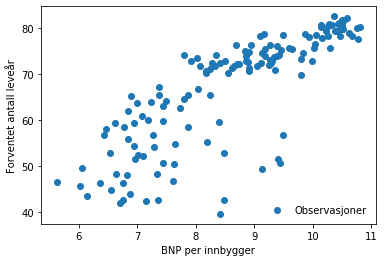

In [2]:
import numpy as np
from matplotlib import pyplot as plt

fig,ax=plt.subplots()

#adding axis lables:
ax.set_ylabel('Forventet antall leveår')
ax.set_xlabel('BNP per innbygger')

#plotting the function:
ax.scatter(np.log(g['gdp_cap']), g['life_exp'],  label='Observasjoner')
ax.legend(loc='lower right',frameon=False)

Vi ønsker imidlertid å lage en litt mer interessant fremstilling enn dette ved å 

1. Oversette navene på verdensdeler fra engelsk til norsk
2. Lage spesielle fargekoder for hver verdensdel
3. La størrelsen på prikkene indikere størrelse på land
3. Skape interaktivitet ved at det popper opp opplysningeer om navn, BNP, levealder og befolkning når man holder pekere over. 


Det første vi må gjøre for å få til det er å lage en datasettet som inneholder de dataene vi trenger for å få til dette. Vi starter med 1. og 2., ved å lage oppslag som definerer norske navn og fargekode. Disse brukes så med pandas `apply`-funksjon til å definere en kolonne `continent_no` med norske navn og en `colors`-kolonne:

In [3]:
#creating a dictionary of continents with norwegian translation:
continents={'Africa': 'Afrika', 'Americas': 'Sør/Nord-Amerika', 'Asia': 'Asia', 'Europe': 'Europa', 'Oceania': 'Oseania'}
#assigning a color hex-code to each continent
colors={'Africa': '#E14827', 'Americas': '#84E127', 'Asia': '#2792E1', 'Europe': '#BC27E1', 'Oceania': '#E04A6C'}


g['continent_no']=g['continent'].apply(lambda cont:  continents[cont])
g['colors']=g['continent'].apply(lambda cont: colors[cont])
g

,country,year,population,continent,life_exp,gdp_cap,continent_no,colors
11,Afghanistan,2007,31889923,Asia,43.828,974.580338,Asia,#2792E1
23,Albania,2007,3600523,Europe,76.423,5937.029526,Europa,#BC27E1
35,Algeria,2007,33333216,Africa,72.301,6223.367465,Afrika,#E14827
47,Angola,2007,12420476,Africa,42.731,4797.231267,Afrika,#E14827
59,Argentina,2007,40301927,Americas,75.320,12779.379640,Sør/Nord-Amerika,#84E127
...,...,...,...,...,...,...,...,...
1655,Vietnam,2007,85262356,Asia,74.249,2441.576404,Asia,#2792E1
1667,West Bank and Gaza,2007,4018332,Asia,73.422,3025.349798,Asia,#2792E1
1679,"Yemen, Rep.",2007,22211743,Asia,62.698,2280.769906,Asia,#2792E1
1691,Zambia,2007,11746035,Africa,42.384,1271.211593,Afrika,#E14827


Punkt 3. var at størrelsen på prikkene skal indikere land. Da trenger vi en kolonne som angir størrelse i pikser, som python forstår, i stedet for faktisk befolkning. Variasjonen i befolkning er også så stor at vi tar roten av den faktiske befolkningen for at det skal se penere ut. Formelen for størrelse på prikkene settes derfor til `pop**0.5/300`, der `pop`er befolkning i millioner.

In [4]:
g['size']=g['population'].apply(lambda pop: pop**0.5/300)
g[g['country']=='India']

,country,year,population,continent,life_exp,gdp_cap,continent_no,colors,size
707,India,2007,1110396331,Asia,64.698,2452.210407,Asia,#2792E1,111.075366


Vi ser over at for India blir for eksempel størrelsen da 111 piksler. 

Til sist definerer vi variablene som skal poppe opp når vi holder pekeren over en prikk. For å få norsk tusenskilletegn, med mellomrom, benytter vi følgende konvertering:

In [5]:
'{:,}'.format(int(23153161365)).replace(',',' ')

'23 153 161 365'

Vi kan nå, med norsk tusenskilletegn, definere BNP i norske kroner (vekslingskurs 8.9NOK/USD), forventet livslengde i heltall og befolkning i millioner, i heltall. 

In [6]:
g['gdp_capNOK']=g['gdp_cap'].apply(lambda gdp: '{:,}'.format(int(8.9*gdp)).replace(',',' '))
g['life_exp_rnd']=g['life_exp'].apply(lambda l: int(l))
g['pop_mill_str']=g['population'].apply(lambda pop:  '{:,}'.format(int(pop/1000000)))
g

,country,year,population,continent,life_exp,gdp_cap,continent_no,colors,size,gdp_capNOK,life_exp_rnd,pop_mill_str
11,Afghanistan,2007,31889923,Asia,43.828,974.580338,Asia,#2792E1,18.823721,8 673,43,31
23,Albania,2007,3600523,Europe,76.423,5937.029526,Europa,#BC27E1,6.325015,52 839,76,3
35,Algeria,2007,33333216,Africa,72.301,6223.367465,Afrika,#E14827,19.244975,55 387,72,33
47,Angola,2007,12420476,Africa,42.731,4797.231267,Afrika,#E14827,11.747565,42 695,42,12
59,Argentina,2007,40301927,Americas,75.320,12779.379640,Sør/Nord-Amerika,#84E127,21.161266,113 736,75,40
...,...,...,...,...,...,...,...,...,...,...,...,...
1655,Vietnam,2007,85262356,Asia,74.249,2441.576404,Asia,#2792E1,30.779206,21 730,74,85
1667,West Bank and Gaza,2007,4018332,Asia,73.422,3025.349798,Asia,#2792E1,6.681926,26 925,73,4
1679,"Yemen, Rep.",2007,22211743,Asia,62.698,2280.769906,Asia,#2792E1,15.709779,20 298,62,22
1691,Zambia,2007,11746035,Africa,42.384,1271.211593,Afrika,#E14827,11.424163,11 313,42,11


### *bokeh*

Vi skal bruke en pakke som heter `bokeh` til å lage en interaktiv figur og nettside, av datasettet vi nettopp laget ferdig. Vi starter med å definere figuren. I Eksempel 1 lager vi en figur ved å kalle på figurfunksjonen i bokeh. 

* De første fire argumentene definerer tittel og navn på aksene. 
* `x_axis_type = "log"` har samme effekt som å konvertere BNP til log i [10 - statsmodels](10%20-%20statsmodels.ipynb), men med den forskjell at det er benevningen på aksen og ikke selve variabelen som konverteres. 
* Så defineres at det skal være en interaktiv graf som skal reagere på at pekeren beveges over, med `tools = "hoover"`.
* Pekeren skal åpne en boks med en liten liste med navn på land, BNP/Innbygger, forventet levealder og Befolkning. Dette oppnås med argumentet `tooltips`. Hvert element i listen er en `tuple` med tekst som skal vises, og hilken kolonne dataene skal hentes fra. For eksempel betyr `("Land","@country")` at på den første linjen skal teksten "Land" vises, og informasjonen skal hentes fra kolonnen "country" i datasettet. 
* Til sist settes størrelsen på plottet


#### Eksempel 1:

In [7]:
from bokeh.plotting import figure

#creating figure:
p = figure(
        title = "Levealder og BNP per innbygger", 
        x_axis_label = 'BNP per innbygger (NOK)',
        y_axis_label = 'Forventet antall leveår',
    
        x_axis_type = "log",
    
        tools="hover", 
        tooltips = [
            ("Land","@country"),
            ("BNP/innbygger","@gdp_capNOK"),
            ("Forventet alder","@life_exp_rnd"),
            ("Befolkning","@pop_mill_str")
            ],
    
        plot_height = 580,
        plot_width = 980)

Vi kan nå definere hva slags plott vi skal ha. Vi skal ha et scatter-plott som i [10 - statsmodels](10%20-%20statsmodels.ipynb), men dette blir altså interaktivt. Vi bruker da funksjonen `scatter`:

In [8]:
from bokeh.io import show, output_notebook
from bokeh.plotting import output_file

p.scatter(
    source=g,
    
    x= 'gdp_cap', 
    y= 'life_exp', 
    size='size', 
    color= 'colors',
    legend_field='continent_no',
    
    alpha= 0.8
    )

#Creating the graph and saving as html
output_notebook()
output_file("BNP_levealder.html")
show(p)

Loading BokehJS ...

I funksjonen `scatter` over angis datasettet med det første argumentet (`source=g`). Etter det angis hvilken kolonne som skal angi henholdsvis x-akse, y-akse, størrelse, farge og etikettnavn. Til sist angis at prikkene skal være 20% gjennomsiktig. 

Etter å ha definert plottet kalles 
* `output_notebook()` gir beskjed om at grafen skal vises i jupyter
* `output_file("BNP_levealder.html")` angir at html-filen som skal lagres skal hete "BNP_levealder.html"
* `show(p)` genererer html-filen og visning

Men det er grunn til ikke å være helt fornøyd med resultatet. For det første bør benvenelsen på x-aksen være mer lesevennlig. Vi endrer derfor denne fra vitenskapelig format til 1k, 10k og 100k, der k=1000. Etikettene ligger delvis over plottene, så vi flytter den til "top_left". I tillegg ser ikke linjene pene ut på en nettside, så vi fjerner de fleste av dem. Det kan vi gjøre med følgende kode:

In [9]:
#formatting:
p.xaxis.major_label_overrides = { 1000: '1k', 10000: '10k', 100000: '100k' }
p.legend.location = "top_left"

p.legend[0].border_line_alpha=0
p.outline_line_alpha=0
p.grid[0].grid_line_alpha=0
p.grid[1].grid_line_alpha=0

output_notebook()
output_file("BNP_levealder.html")
show(p)

Loading BokehJS ...

### *Oppsummering*

For å oppsummere, så importerer vi og behandler datasette slik:

In [10]:
import pandas as pd
g = pd.read_csv("https://titlon.uit.no/hht/data/gapminder.csv", index_col=0)#reading data

#Assigning norwegian translations to english continent names
continents={'Africa': 'Afrika', 'Americas': 'Sør/Nord-Amerika', 'Asia': 'Asia', 'Europe': 'Europa', 'Oceania': 'Oseania'}
g['continent_no']=g['continent'].apply(lambda cont:  continents[cont])

#assigning a color to each continent
colors={'Africa': '#E14827', 'Americas': '#84E127', 'Asia': '#2792E1', 'Europe': '#BC27E1', 'Oceania': '#E04A6C'}
g['colors']=g['continent'].apply(lambda cont: colors[cont])

#defining plot size
g['size']=g['population'].apply(lambda pop: pop**0.5/300)

#Calulating and formatting GDP per capita, life expextancy and population
g['gdp_capNOK']=g['gdp_cap'].apply(lambda gdp: '{:,}'.format(int(8.9*gdp)).replace(',',' '))
g['life_exp_rnd']=g['life_exp'].apply(lambda l: int(l))
g['pop_mill_str']=g['population'].apply(lambda pop:  '{:,}'.format(int(pop/1000000)))

Og grafen og nettsiden lages slik

In [11]:
from bokeh.io import show, output_notebook
from bokeh.plotting import output_file, figure

#creating figure:
p = figure(
        title = "Levealder og BNP per innbygger", 
        x_axis_label = 'BNP per innbygger (NOK)',
        y_axis_label = 'Forventet antall leveår',
    
        x_axis_type = "log",
    
        tools="hover", 
        tooltips = [
            ("Land","@country"),
            ("BNP/innbygger","@gdp_capNOK"),
            ("Forventet alder","@life_exp_rnd"),
            ("Befolkning","@pop_mill_str")
            ],
    
        plot_height = 580,
        plot_width = 980)

p.scatter(
    source=g,
    
    x= 'gdp_cap', 
    y= 'life_exp', 
    size='size', 
    color= 'colors',
    legend_field='continent_no',
    
    alpha= 0.8
    )

#formatting:
p.xaxis.major_label_overrides = { 1000: '1k', 10000: '10k', 100000: '100k' }
p.legend.location = "top_left"

p.legend[0].border_line_alpha=0
p.outline_line_alpha=0
p.grid[0].grid_line_alpha=0
p.grid[1].grid_line_alpha=0

#Creating the graph and saving as html
output_notebook()
output_file("BNP_levealder.html")
show(p)

Loading BokehJS ...

## Interaktivt kart

Interaktivt kart [som vist her](https://titlon.uit.no/hht/index.php?page=2):

### *Importerer data*

In [12]:
import pandas as pd

data=pd.read_csv(
    r"https://titlon.uit.no/hht/data/valgkretser/data.csv",
    encoding="latin-1",
    delimiter=";")  
data

,Bydel,Inntekt,Formue,Skatt,Alder,Skattepliktige,Andel med høyere utdanning,Rødhet,ApSVRV,HFrp,Mynter,Lat,Lon
0,Bjerkaker,355 654,677 004,125 076,55.0,6 963,69.7,-0.200,0.448,0.248,8.0,69.642929,18.905919
1,Hamna,354 089,394 295,125 517,52.0,2 785,66.2,-0.208,0.431,0.223,1.0,69.708994,18.981154
2,Kaldfjord,300 249,469 818,101 027,57.0,3 581,51.4,0.095,0.255,0.350,3.0,69.675000,18.756800
3,Kattfjord,237 737,473 271,75 624,57.0,245,26.5,0.260,0.120,0.380,3.0,69.622966,18.307996
4,Kroken,277 682,369 369,92 059,60.0,4 206,43.8,-0.093,0.348,0.255,1.0,69.684100,19.072100
5,Kvaløysletta,338 632,504 744,117 810,55.0,4 869,61.0,-0.082,0.342,0.260,4.0,69.688400,18.856900
6,Lakselvbukt,240 095,614 059,69 575,66.0,647,22.5,-0.231,0.403,0.172,6.0,69.460350,19.729821
7,Malangshalvøya,251 949,479 646,80 005,61.0,231,NaN,-0.176,0.338,0.162,3.0,69.513294,18.749502
8,Mortensnes,320 395,543 649,109 871,57.0,3 211,76.2,-0.209,0.454,0.245,5.0,69.679948,18.922906
9,Ramfjord,252 236,459 362,76 676,63.0,1 066,32.3,0.214,0.142,0.356,3.0,69.561400,19.182000


Importerer geodata:

In [13]:
import geopandas as gpd
#loading the geographical data
#and converting to a coordinate system that folium understands:
geodata = gpd.read_file(r"https://titlon.uit.no/hht/data/valgkretser.zip")
geodata=geodata.to_crs('epsg:4326') 
geodata

,DATO,VKRETS_VKR,KOMM,OPPHAV,OPPDATERIN,OBJTYPE,GEOMETRITY,VKRETS_V_1,geometry
0,0,0,5401,"abas, dek og ssb grunnkretser",2.018042e+11,Valgkrets,10,Malangshalvøya,"POLYGON ((18.47644 69.52988, 18.51169 69.53640..."
1,0,0,5401,"abas, dek og ssb grunnkretser",2.018042e+11,Valgkrets,10,Ringvassøy,"POLYGON ((18.63313 69.90560, 18.66172 69.92736..."
2,0,0,5401,"abas, dek og ssb grunnkretser",2.018042e+11,Valgkrets,10,Sommarøy,"POLYGON ((17.70497 69.69430, 17.95871 69.70466..."
3,0,0,5401,"abas, dek og ssb grunnkretser",2.018042e+11,Valgkrets,10,Hamna,"POLYGON ((19.03735 69.73702, 19.04254 69.72157..."
4,0,0,5401,"abas, dek og ssb grunnkretser",2.018042e+11,Valgkrets,10,Kattfjord,"POLYGON ((18.16256 69.71271, 18.18350 69.71413..."
5,0,0,5401,"abas, dek og ssb grunnkretser",2.018042e+11,Valgkrets,10,Kroken,"POLYGON ((19.11535 69.77302, 19.23057 69.78766..."
6,0,0,5401,"abas, dek og ssb grunnkretser",2.018042e+11,Valgkrets,10,Stakkevollan,"POLYGON ((19.04254 69.72157, 19.04927 69.70125..."
7,0,0,5401,"abas, dek og ssb grunnkretser",2.018042e+11,Valgkrets,10,Tromsdalen,"POLYGON ((18.96265 69.64267, 18.96535 69.64391..."
8,0,0,5401,"abas, dek og ssb grunnkretser",2.018042e+11,Valgkrets,10,Sentrum,"POLYGON ((18.89095 69.67118, 18.90664 69.67316..."
9,0,0,5401,"abas, dek og ssb grunnkretser",2.018042e+11,Valgkrets,10,Ramfjord,"POLYGON ((19.00396 69.60616, 19.01408 69.60478..."


Behandler data:

In [14]:
#pandas does not handle æ, ø å, so creates columns in both the demographic data and geodata that can be matched:
data['Bydel_dec']=data['Bydel'].apply(lambda s: str(s).encode('ascii','ignore').decode('ascii')) 
geodata['Bydel_dec']=geodata['VKRETS_V_1'].apply(lambda s: s.encode('ascii','ignore').decode('ascii')) 

#for example
display(geodata[geodata['VKRETS_V_1']=='Ringvassøy'])
display(data[data['Bydel']=='Ringvassøy'])

,DATO,VKRETS_VKR,KOMM,OPPHAV,OPPDATERIN,OBJTYPE,GEOMETRITY,VKRETS_V_1,geometry,Bydel_dec
1,0,0,5401,"abas, dek og ssb grunnkretser",2.018042e+11,Valgkrets,10,Ringvassøy,"POLYGON ((18.63313 69.90560, 18.66172 69.92736...",Ringvassy


,Bydel,Inntekt,Formue,Skatt,Alder,Skattepliktige,Andel med høyere utdanning,Rødhet,ApSVRV,HFrp,Mynter,Lat,Lon,Bydel_dec
10,Ringvassøy,256 291,462 820,84 786,58.0,133,NaN,-0.065,0.23,0.165,3.0,69.887738,18.981047,Ringvassy


### *Lager kart*

Vi starter med å definere startpunktet i pakken `folium`

In [23]:
import webbrowser
import folium

#Creating the map
tromso=folium.Map(location=[69.67, 18.98],zoom_start=10)

#Creating the html file
tromso.save('tromso.html')

#Open the html in new tab
webbrowser.open('tromso.html')

True

Vi har nå et kart, som vi nå skal fylle med informasjonen vi ordnet i forrige avsnitt. `webbrowser.open('tromso.html')` åpner html-filen i en ny fane. 

Følgende kode bruker funksjonen `Choropleth` til å legge et lag over eksisterende kart med kommunegrensene fra 

In [24]:
#adding the colour overlay displaying "redness" of municipalities:
f=folium.Choropleth(
    geo_data=geodata,
    name="choropleth",
    columns=["Bydel_dec", "Rødhet"],
    data=data,
    key_on="feature.properties.Bydel_dec",
    fill_color="RdBu",
    nan_fill_color='white',
    fill_opacity=0.5,
    legend_name="Valgresultat oppslutning H+Frp minus Ap+SV+Rødt"
).add_to(tromso)

folium.LayerControl().add_to(tromso)

#Saving a new html wtih colour overlay
tromso.save('tromso.html')

Legger informasjon til kartet. Vi starter med å lenke bydelene i datasettet vårt (`data`) med bydelene i kartdatene våre (`geodata`). Vi ordner samtidig dataene slik at vi får prosenter i stedet for desimaler:

In [25]:
import math

#the data needs to be merged on a variable with the same name:
geodata['Bydel']=geodata['VKRETS_V_1']

#merging the demographic data into the geodata:
geodata_merged=geodata.merge(data,on='Bydel')

#cleaning data
geodata_merged['Andel med høyere utdanning']=geodata_merged['Andel med høyere utdanning'].apply(
    
    lambda x: f"{int(x)}%"
    if not math.isnan(x) else 'NA')

geodata_merged['Rødhet']=geodata_merged['Rødhet'].apply(
    
    lambda x: f"{int(x)*100}%"  
    if  not math.isnan(x) else 'NA')

geodata_merged['ApSVRV']=geodata_merged['ApSVRV'].apply(
    
    lambda x: f"{int(x)*100}%"  
    if not math.isnan(x) else 'NA')

geodata_merged['HFrp']=geodata_merged['HFrp'].apply(
    
    lambda x:  f"{int(x)*100}%"  
    if not math.isnan(x) else 'NA')



Vi itererer så gjennom alle bydelene, og legger til en markør som viser *vertøytips* (tooltip), som er informasjon du får når du beveger musa over. 

Først i iterasjonen finner vi breddegraden ("Lat") og lengdegraden ("lon") i geodata_merged-tabellen. Så lager vi en tekst-streng i html-format, som har fem linjer med informasjon som vises når musa beveger seg over markøren.

Vi setter markøren i `folium` med `Market`-klassen, der det første argumentet er koordinatene på kartet, det andre argumentet er verktøytipset, altså tekstrengen som ble laget. Tredje argument angir at markøren skal være rød. 


In [26]:
for i,r in geodata_merged.iterrows():
    #obtaining coordinates:
    lat=float(r['Lat'])
    lon=float(r['Lon'])   

    #tooltips text:
    t=(f"<b>{r['Bydel']}</b><br>"
        f"Inntekt: {          r['Inntekt']                    }<br>"
        f"Alder: {            r['Alder']                      }<br>"
        f"Høyere utdanning: { r['Andel med høyere utdanning'] }<br>"
        f"Ap+SV+Rødt: {       r['ApSVRV']                     }<br>"
        f"H+FrP: {            r['HFrp']                       }")
    
    #setting the marker:
    folium.Marker(
        [lat,lon-0.01],
        tooltip=t,
        icon=folium.Icon(color='red')
    ).add_to(tromso)
    
    
#saving the map as a html file:
tromso.save('./tromso.html')

Vi skal nå lage en stabel med mynter som skal representere gjennomsnittsinntekten  I mappen img/coins/ ligger det bilder av én til ti mynter stablet i høyden <img align="right" src="img/coins/6coins.png" style="padding:20px;"><img align="right" src="img/coins/7coins.png" style="padding:20px;"><img align="right" src="img/coins/8coins.png" style="padding:20px;">
Vi illustrerer inntekt ved å velge bilde etter antall mynter angitt i kollonnen 'Mynter' i datasettet. Dette er gjort i eksemplet under:

In [27]:
for i,r in geodata_merged.iterrows():
    #obtaining coordinates:
    lat=float(r['Lat'])
    lon=float(r['Lon']) 
    
    #creating pin for wealth. The height of the stack of coins is determined by the 
    #   picture file f"./img/{int(r['Mynter'])}coins.png":
    icon=folium.features.CustomIcon(f"img/coins/{int(r['Mynter'])}coins.png")
    folium.Marker([lat,lon+0.01],tooltip=f"Formue:{r['Formue']}",icon=icon).add_to(tromso)
    
#saving the map as a html file:
tromso.save('./tromso.html')
webbrowser.open('tromso.html')

True

## Oppgave

Gjør som i [10 - statsmodels](10%20-%20statsmodels.ipynb), og beregn regressionskoefisientene på akkurat samme måte med `res=OLS(y,x).fit()`. Lag så en regressjonslinje på samme måte som i [10 - statsmodels](10%20-%20statsmodels.ipynb). Tips:

* Siden x_aksen er på log-form, må x verdiene i `linspace`-funksjonene være i nivå, og ikke log-konvertert. 
* Av samme grunn må det tas log av `x` i definisjonen av `regression_line`
* i bokeh bruker du funksjonen `line` i stedet for `plot` for å lage en linje, og funksjonen anvendes på figur-objektet du har skapt, i stedet for `ax`-objektet. 

##### [< Forrige](10%20-%20statsmodels.ipynb)     |     [Neste >](12%20-%20animasjon%20med%20klasse.ipynb)